In [2]:
import sys
sys.path.append("../../../../src")
sys.path.append("../../")
import os
import numpy as np
import pickle
from example_pendulum import get_pendulum_data, pendulum_to_movie
from scipy.integrate import odeint
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate_order2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
tf.config.set_visible_devices([], 'GPU')

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
tf.compat.v1.disable_eager_execution()

In [4]:
data_path = '../../sindy_models/original/'
save_name = 'model2'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

## Single trajectory plots

In [5]:
t = np.arange(0, 20, .02)
z0s = np.pi/np.array([1.5,2,3,4,8,16])
dz0s = .5*np.ones(z0s.shape)

f  = lambda z, t : [z[1], -np.sin(z[0])]
n_ics = z0s.size

z = np.zeros((n_ics,t.size,2))
dz = np.zeros(z.shape)
for i in range(n_ics):
    z[i] = odeint(f, [z0s[i],dz0s[i]], t)
    dz[i] = np.array([f(z[i,j], t[j]) for j in range(len(t))])
    
x,dx,ddx = pendulum_to_movie(z,dz)

In [6]:
test_data = {}
test_data['x'] = x.reshape((-1,params['input_dim']))
test_data['dx'] = dx.reshape((-1,params['input_dim']))
test_data['ddx'] = ddx.reshape((-1,params['input_dim']))
test_data['z'] = z[:,:,0].reshape((-1,params['latent_dim']))
test_data['dz'] = z[:,:,1].reshape((-1,params['latent_dim']))
test_data['ddz'] = dz[:,:,1].reshape((-1,params['latent_dim']))

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model2


In [8]:
true_coefficients = np.zeros(test_set_results['sindy_coefficients'].shape)
true_coefficients[-2] = -1.

z_sim = np.zeros((n_ics, t.size, 2))
pendulum_sim = np.zeros(z_sim.shape)
for i in range(n_ics):
    z_sim[i] = sindy_simulate_order2(test_set_results['z'][i*t.size], test_set_results['dz'][i*t.size], t,
                                     params['coefficient_mask']*test_set_results['sindy_coefficients'],
                                     params['poly_order'], params['include_sine'])
    pendulum_sim[i] = sindy_simulate_order2(test_data['z'][i*t.size], test_data['dz'][i*t.size], t,
                                            true_coefficients,
                                            params['poly_order'], params['include_sine'])

([], [])

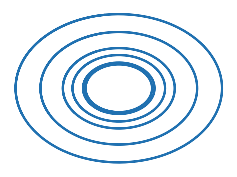

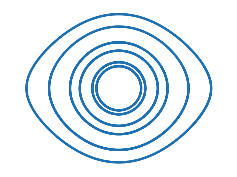

In [9]:
plt.figure(figsize=(4,3))
plt.plot(z_sim[:,:,0].T, z_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(4,3))
plt.plot(pendulum_sim[:,:,0].T, pendulum_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

<ipython-input-10-4fd85e9b5649>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)


(-49.95, 1048.95, -1.5490991720965075, 1.7982758664394682)

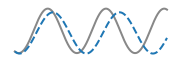

In [10]:
ic_idx = 1

plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[ic_idx,:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

## Test set analysis - in distribution

In [11]:
with open('../../test_data_max_variance.pkl', 'rb') as file:
    test_data = pickle.load(file)

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from ../../sindy_models/original/model2


# Unexplained Variance

In [13]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.var(test_data['x'])
decoder_ddx_error = np.mean((test_data['ddx'] - test_set_results['ddx_decode'])**2)/np.var(test_data['ddx'])
sindy_ddz_error = np.mean((test_set_results['ddz'] - test_set_results['ddz_predict'])**2)/np.var(test_set_results['ddz'])

print(f'Decoder relative error: {decoder_x_error:.2e}')
print(f'Decoder relative SINDy error: {decoder_ddx_error:.2e}')
print(f'SINDy reltive error, z: {sindy_ddz_error:.2e}')

Decoder relative error: 3.29e-04
Decoder relative SINDy error: 7.63e-04
SINDy reltive error, z: 1.30e-01


# Authors Errors

In [14]:
# (Reference: 4.3)

# Original Notebook:
# Decoder relative error: 0.000927
# Decoder relative SINDy error: 0.000996
# SINDy reltive error, z: 0.214550

In [15]:
# Verified Results with 10 random initial conditions 

# 1
# Decoder relative error: 0.000411
# Decoder relative SINDy error: 0.000964
# SINDy reltive error, z: 0.172356

# 2
# Decoder relative error: 0.001952
# Decoder relative SINDy error: 0.001505
# SINDy reltive error, z: 0.381023

# 3
# Decoder relative error: 0.000729
# Decoder relative SINDy error: 0.000947
# SINDy reltive error, z: 0.217798

# 4
# Decoder relative error: 0.000214
# Decoder relative SINDy error: 0.000527
# SINDy reltive error, z: 0.094515

# 5
# Decoder relative error: 0.001920
# Decoder relative SINDy error: 0.001103
# SINDy reltive error, z: 0.282630

# MEAN +- STD
# Decoder relative error: (1.0452 +- 0.07457) * 10^-3
# Decoder relative SINDy error: (1.0092 +- 0.3140) * 10^-3
# SINDy reltive error, z: 0.2296 +- 0.0973

In [16]:
# Verified Results with 50 random initial conditions 

# 1 
# Decoder relative error: 0.002597
# Decoder relative SINDy error: 0.001117
# SINDy reltive error, z: 0.237989

# 2
# Decoder relative error: 0.000556
# Decoder relative SINDy error: 0.000963
# SINDy reltive error, z: 0.189963

# 3
# Decoder relative error: 0.000907
# Decoder relative SINDy error: 0.000823
# SINDy reltive error, z: 0.168132

# 4
# Decoder relative error: 0.001966
# Decoder relative SINDy error: 0.000954
# SINDy reltive error, z: 0.201816

# 5
# Decoder relative error: 0.002365
# Decoder relative SINDy error: 0.001148
# SINDy reltive error, z: 0.334752

# MEAN +- STD
# Decoder relative error: (1.678 +- 0.806) * 10^-3
# Decoder relative SINDy error: (1.001 +- 0.1186) * 10^-3
# SINDy reltive error, z: 0.22653 +- 0.05865

In [17]:
import pandas as pd

In [18]:
def sindy_library_tf_order2(z, dz, latent_dim, poly_order, include_sine=False):
    """
    Build the SINDy library for a second order system. This is essentially the same as for a first
    order system, but library terms are also built for the derivatives.
    """
    library = ['1']

    z_combined = z + dz

    for i in range(2*latent_dim):
        library.append(z_combined[i])

    if poly_order > 1:
        for i in range(2*latent_dim):
            for j in range(i,2*latent_dim):
                library.append(f'{z_combined[i]}*{z_combined[j]}')

    if poly_order > 2:
        for i in range(2*latent_dim):
            for j in range(i,2*latent_dim):
                for k in range(j,2*latent_dim):
                    library.append(f'{z_combined[i]}*{z_combined[j]}*{z_combined[k]}')

    if poly_order > 3:
        for i in range(2*latent_dim):
            for j in range(i,2*latent_dim):
                for k in range(j,2*latent_dim):
                    for p in range(k,2*latent_dim):
                        library.append(f'{z_combined[i]}*{z_combined[j]}*{z_combined[k]}*{z_combined[p]}')

    if poly_order > 4:
        for i in range(2*latent_dim):
            for j in range(i,2*latent_dim):
                for k in range(j,2*latent_dim):
                    for p in range(k,2*latent_dim):
                        for q in range(p,2*latent_dim):
                            library.append(f'{z_combined[i]}*{z_combined[j]}*{z_combined[k]}*{z_combined[p]}*{z_combined[q]}')

    if include_sine:
        for i in range(2*latent_dim):
            library.append(f'sin({z_combined[i]})')

    return library

In [19]:
coefficient_names = sindy_library_tf_order2(['z1', 'z2'], ['dz1', 'dz2'], params['latent_dim'], params['poly_order'], include_sine=True)
coefficient_names

['1',
 'z1',
 'z2',
 'z1*z1',
 'z1*z2',
 'z2*z2',
 'z1*z1*z1',
 'z1*z1*z2',
 'z1*z2*z2',
 'z2*z2*z2',
 'sin(z1)',
 'sin(z2)']

In [20]:
test_set_results['sindy_coefficients']

array([[-7.3453793e-06],
       [-5.1572436e-01],
       [-2.8153381e-05],
       [ 1.0436754e-05],
       [ 6.8249756e-06],
       [-1.4628322e-05],
       [-1.3901247e-05],
       [ 2.4902638e-05],
       [ 7.2452408e-06],
       [ 7.2009243e-06],
       [ 6.8196305e-06],
       [-4.4562712e-06]], dtype=float32)

In [21]:
masked_coefficients = np.array([[(c[0].round(3) if m else '-') for c, m in zip(coefficients, mask)] for coefficients, mask in zip([test_set_results['sindy_coefficients']], [params['coefficient_mask']])]).reshape(1, 12)#.round(3)

In [22]:
pd.DataFrame(masked_coefficients, columns=coefficient_names)

1      z1 z2 z1*z1 z1*z2 z2*z2 z1*z1*z1 z1*z1*z2 z1*z2*z2 z2*z2*z2 sin(z1)  \
0  -  -0.516  -     -     -     -        -        -        -        -       -   

  sin(z2)  
0       -